In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [5]:
# Calculate distance on sphere
def haversince_distance(df, lat1, long1, lat2, long2):
    """
    Calculates distance between 2 sets of GPS coordinates in df
    """
    
    r = 6371
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
         
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
# Create new column
df['dist_km'] = haversince_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [7]:
df.info()  # datetime object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])  # convert to python datetime object - CARE: WILL BE IN UTC

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [10]:
my_time = df['pickup_datetime'][0]
my_time

Timestamp('2010-04-19 08:17:56+0000', tz='UTC')

In [11]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [12]:
df['Hour'] = df['EDTdate'].dt.hour

In [13]:
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')  # could also use costum function and apply

In [14]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm


In [15]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")  # or dayofweek for a int representation of day
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [16]:
# Now seperate categorial from continuous columns

In [17]:
cat_cols = ['Hour', 'AMorPM','Weekday']  # Hour could be both
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'dist_km']

In [18]:
y_col = ['fare_amount']  # Label we want to use -> fare_amount or fare_class with classification problem

In [19]:
df.dtypes  

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [20]:
# NOW: Chage datatypes into category
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [21]:
df['Hour'].head()  # 24 different categories here for this type

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [22]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [23]:
df['AMorPM'].cat.codes  #am->0,pm->1

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [24]:
df['Weekday'].cat.codes.values  # gets the array of the code values (array used for tensor)

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [25]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [26]:
# Stack categoires together
cats = np.stack([hr,ampm,wkdy], axis=1)  # 
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [27]:
# As one-liner (still need to define cat_cols and convert types to category)
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)

In [28]:
cats = torch.tensor(cats, dtype=torch.int64)

In [29]:
# Now repeat for continous variables
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [30]:
conts = torch.tensor(conts,dtype=torch.float)

In [31]:
# Last thin: Label column
y = torch.tensor(df[y_col].values,dtype=torch.float)

In [32]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
cat_szs

[24, 2, 7]

In [33]:
# Embedding sizes, rule of thumb: sizes divided by 2
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]  # either take 50 or divided by two | +1 if I have onl 2 cats | // we dont want float
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [34]:
catz = cats[:2]  # take a slice
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [35]:
# what happens if we pass this into embedding layer?
# create one layer for each category (hours, amorpm, weekday)
selfembeds = nn.ModuleList(nn.Embedding(ni,nf) for ni,nf in emb_szs)  # ni-> number of embeddings/categories, nf -> embedding dimension/size
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [36]:
# FORWARD METHOD: Applying values to one hot encodings ([0,1,0,0,0]) -> Floats are less memory consuming, represent categories in compressed dimension

embeddingsz = []

for i,e in enumerate(selfembeds):
    embeddingsz.append(e(catz[:,i]))

In [37]:
embeddingsz  # 12 items in first tensor, 1 in second, 4 in third (per item)

[tensor([[-1.1177, -0.8766,  1.3800, -0.3606, -1.5531,  1.5879,  0.6874, -0.9083,
           1.0290,  0.2292, -0.7437,  0.2259],
         [ 1.2966, -0.8889, -0.0909, -1.2978,  1.0588, -1.1247,  0.5627,  0.4815,
           0.2677,  0.1014,  1.3074, -0.5103]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.0391],
         [-0.0391]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.2585, -1.7834,  0.7050,  0.2880],
         [ 0.3516, -0.3570, -0.0842,  1.0121]], grad_fn=<EmbeddingBackward0>)]

In [38]:
z = torch.cat(embeddingsz,1)  # first entries together, second as well...
z

tensor([[-1.1177, -0.8766,  1.3800, -0.3606, -1.5531,  1.5879,  0.6874, -0.9083,
          1.0290,  0.2292, -0.7437,  0.2259, -0.0391,  0.2585, -1.7834,  0.7050,
          0.2880],
        [ 1.2966, -0.8889, -0.0909, -1.2978,  1.0588, -1.1247,  0.5627,  0.4815,
          0.2677,  0.1014,  1.3074, -0.5103, -0.0391,  0.3516, -0.3570, -0.0842,
          1.0121]], grad_fn=<CatBackward0>)

So we now have encoded categories in embedding vectors (advantage thanks to float values compared to 1 and 0: smaller vector (half here))

In [39]:
selfembdrop = nn.Dropout(0.4)  # randomly turns off neurons with probability 0.4 -> randomly resets weights of certain neurons -> no overfit
# we can usually drop values, since logic implies values: e.g. male=0,female=1; need only one, cause one ipmlies the other

In [40]:
z = selfembdrop(z)
z

tensor([[-1.8629, -1.4610,  2.2999, -0.6010, -0.0000,  2.6465,  0.0000, -1.5138,
          0.0000,  0.0000, -0.0000,  0.3766, -0.0000,  0.0000, -0.0000,  1.1750,
          0.4800],
        [ 0.0000, -1.4815, -0.1514, -2.1630,  0.0000, -1.8745,  0.9379,  0.8026,
          0.0000,  0.0000,  0.0000, -0.8505, -0.0652,  0.0000, -0.5950, -0.1404,
          0.0000]], grad_fn=<MulBackward0>)

### Embedding values get updated throuh backprop and can represent some trend, e.g. for the weekdays: some trend for weekday and weekend

# Build model class (complex but flexible)

In [41]:
class TabularModel(nn.Module):
    
    def __init__(self,emb_szs,n_cont,out_sz,layers,p=0.5):  # probability for dropout layer
    
        # Layers = [200,100,50]  # adjust number of layers of neurons, we can play around with layers
        # e.g. 200 neurons in first layer, 100 in second, ...
    
        super().__init__()

        # Define/Name some functions
        self.embeds = nn.ModuleList(nn.Embedding(ni,nf) for ni,nf in emb_szs)
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont) # normalize continuous data

        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs]) # total number of embedding sizes (halfed numbers)
        n_in = n_emb + n_cont  # categorial and continous data total

        # Setup layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))  # Inplace overwrites previous values
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        # Last ouput layer
        layerlist.append(nn.Linear(layers[-1],out_sz))  # out_sz will be 1, want to predict only one value
        
        # Define the actual throughput function
        self.layers = nn.Sequential(*layerlist)  # Chain a succession of layers in the NN together into a sequence
        
    def forward(self,x_cat,x_cont):  # x_cat: categorial features, x_cont: cont. features passed in
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)  # combine cat with cont. data
        x = self.layers(x)  # run data through NN sequence
        return x

In [50]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],1,[200,100],p=0.4)  # conts.shape[1] gives number of columns, i.e. number of cont. categories

In [51]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [52]:
criterion = nn.MSELoss()  # np.sqrt(MSE)  -> RMSE
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [53]:
# Train/Test splits
batch_size = 60000
test_size = int(batch_size*0.2)  # int for slicing

In [54]:
# DATA WAS SHUFFLED ALREADY, IMPORTANT FOR SLICING
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [55]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [56]:
import time

start_time = time.time()

epochs = 300

losses = []

for i in range(epochs):
    #i += i
    
    y_pred = model(cat_train,con_train)
    loss = torch.sqrt(criterion(y_pred,y_train))  # RMSE
    losses.append(loss.detach().numpy())
    
    if i%10 == 1:
        print(f'epoch: {i} loss is {loss}')
        
    # Backprop:
    
    optimizer.zero_grad()  # don't accumulate gradient from old epoch; would not point towards minimum of cost/loss function
    loss.backward()
    optimizer.step()
    

duration = time.time() - start_time
print(f'Training took {duration/60} minutes')



epoch: 1 loss is 12.481992721557617
epoch: 11 loss is 11.618404388427734
epoch: 21 loss is 11.074576377868652
epoch: 31 loss is 10.70279312133789
epoch: 41 loss is 10.432380676269531
epoch: 51 loss is 10.20926284790039
epoch: 61 loss is 10.010868072509766
epoch: 71 loss is 9.81942081451416
epoch: 81 loss is 9.618820190429688
epoch: 91 loss is 9.393990516662598
epoch: 101 loss is 9.15047836303711
epoch: 111 loss is 8.860879898071289
epoch: 121 loss is 8.539896965026855
epoch: 131 loss is 8.17677116394043
epoch: 141 loss is 7.769925594329834
epoch: 151 loss is 7.337074279785156
epoch: 161 loss is 6.8730244636535645
epoch: 171 loss is 6.398920059204102
epoch: 181 loss is 5.924389839172363
epoch: 191 loss is 5.4376749992370605
epoch: 201 loss is 4.975429534912109
epoch: 211 loss is 4.614530563354492
epoch: 221 loss is 4.283006191253662
epoch: 231 loss is 4.051276206970215
epoch: 241 loss is 3.943601608276367
epoch: 251 loss is 3.866023302078247
epoch: 261 loss is 3.813037157058716
epoch: 2

In [62]:
for j,el in enumerate(losses):
    
    losses[j] = losses[j].detach().numpy()

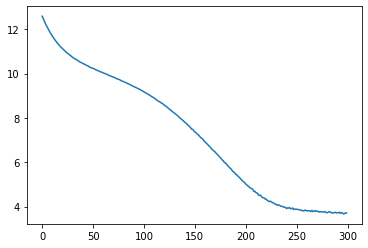

In [64]:
plt.plot(range(epochs),losses)

In [66]:
# Run Test set through model

with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val,y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.63625550


In [76]:
for i in range(10):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i}.) Predicted: {y_val[i].item():8.2f} True: {y_test[i].item():8.2f} Diff: {diff:8.2f}')

0.) Predicted:     5.61 True:     2.90 Diff:     2.71
1.) Predicted:    13.17 True:     5.70 Diff:     7.47
2.) Predicted:     8.02 True:     7.70 Diff:     0.32
3.) Predicted:    14.30 True:    12.50 Diff:     1.80
4.) Predicted:     7.00 True:     4.10 Diff:     2.90
5.) Predicted:     6.14 True:     5.30 Diff:     0.84
6.) Predicted:     1.96 True:     3.70 Diff:     1.74
7.) Predicted:    18.83 True:    14.50 Diff:     4.33
8.) Predicted:     5.22 True:     5.70 Diff:     0.48
9.) Predicted:    14.00 True:    10.10 Diff:     3.90


In [77]:
torch.save(model.state_dict(),'TaxiModel.pt')

## Classification Mode

change out_szs to two (number of classes) initiation of model

criterion changes to nn.CrossEntropyLoss()  (doesn't make sense to measure classification with MSE)

# Now I can use these notebooks as blueprint for new problems